In [62]:
from sqlalchemy import select
from data.db import Person, init_db, ImageStatus

In [2]:
session = init_db()

In [63]:
people = session.execute(select(Person))


for person in people.fetchall():
    for photo in person[0].photos:
        if not photo.save_path.exists():
            photo.status = ImageStatus.NOTDOWNLOADED.value
        else:
            photo.status = ImageStatus.DOWNLOADED.value
        session.merge(photo)
        session.commit()

In [50]:
import matplotlib.pyplot as plt


In [15]:
cursor = conn.cursor()
cursor.execute('SELECT * FROM person INNER JOIN photo ON person.id = photo.person_id WHERE type = "dislike"')
data = cursor.fetchone()

In [16]:
print(data)

('626f17d46e01dc0100f15ab0', 'dislike', 'Joanie', '1993-05-17 20:57:04.492000', '8f6c467e-65a2-4518-937d-ef60684568e9', '626f17d46e01dc0100f15ab0', 'https://images-ssl.gotinder.com/u/eBSsewLW7CqBK4VfkHN1s1/qgSPPcSJZRhnqQtFSRCFED.jpeg?Policy=eyJTdGF0ZW1lbnQiOiBbeyJSZXNvdXJjZSI6IiovdS9lQlNzZXdMVzdDcUJLNFZma0hOMXMxLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2NTI5MDY5NzJ9fX1dfQ__&Signature=OWoQhZLjjJOSfH1UpnAszUyoQ7K-GOG0VYgZQptGAbXuSrCLYn5eEzjGAxZQj1CZhgeKpMLoxhGJMgNPR39jYZzuT10sHi272yLU6InDxWNOf1DIbhkPF345FeDVYw1AG6XrtOqOfPCi8~WcqJzIT8ODsVt9o8neFvodjtkVFXjOd3q1w8uo~t5h5JghcuVwFAPP7AyfYATbuJnKufWkuSElmtRMYjBg~x66GKnW2xSAGPF1Diq8J6HjueUW7ges~0o4bVYzkYRlh88-P8BsrVOT~kDdmMUhJyXOAs4lCk4TMFVT5uHVFZIxKlROg3f9NRdtyAUDmd3-ULGbZL5e9Q__&Key-Pair-Id=K368TLDEUPA6OI', '8f6c467e-65a2-4518-937d-ef60684568e9.jpg', '{"user": {"width_pct": 1.0, "x_offset_pct": 0.0, "height_pct": 0.8, "y_offset_pct": 0.0}, "algo": {"width_pct": 0.4414739, "x_offset_pct": 0.19545719, "height_pct": 0.39

In [7]:
cursor.close()

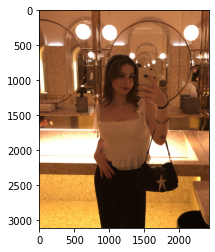

In [11]:
from urllib import request
import matplotlib.pyplot as plt

f = request.urlopen(photos[2]['url'])

# [p['url'] for p in photos]

a = plt.imread(f, format='jpeg')
plt.imshow(a)
plt.show()